<a href="https://colab.research.google.com/github/ivanpalenciab/Prediccion-atlantico/blob/master/3_red_neuronal_densa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install optuna

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

#modulos sklearn
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler


#modulos keras
from keras.models import Sequential
from keras.layers import Dense,Flatten
from keras.optimizers import  RMSprop

In [ ]:
modo_1 = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/Fase 5 (Datos Atlantico)/Pruebas/emd_modes/Modo_1.csv")
modo_2 = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/Fase 5 (Datos Atlantico)/Pruebas/emd_modes/Modo_2.csv")
residuo = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/Fase 5 (Datos Atlantico)/Pruebas/emd_modes/Residuo.csv")
modo_1["FECHA"] = pd.to_datetime(modo_1["FECHA"],format='%Y-%m-%d')
modo_2["FECHA"] = pd.to_datetime(modo_2["FECHA"],format='%Y-%m-%d')
residuo["FECHA"] = pd.to_datetime(residuo["FECHA"],format='%Y-%m-%d')
modo_1.set_index("FECHA", inplace=True)
modo_2.set_index("FECHA", inplace=True)
residuo.set_index("FECHA", inplace=True)

<Axes: xlabel='FECHA'>

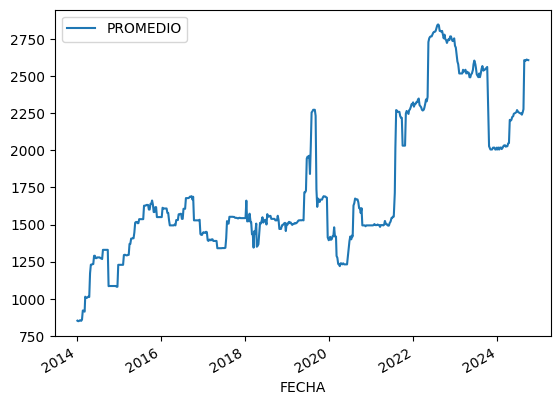

In [ ]:
datos_emd =modo_1 + modo_2 + residuo
datos_emd.plot()

In [ ]:
datos_emd.describe()

,PROMEDIO
count,554.000000
mean,1746.012635
std,484.698883
min,848.000000
25%,1448.000000
50%,1543.000000
75%,2162.500000
max,2850.000000


In [ ]:
futuros = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/Fase 5 (Datos Atlantico)/Datos históricos Futuros maíz EE.UU..csv" )
futuros = futuros[["Fecha","Último"]]
futuros["Fecha"]=pd.to_datetime(futuros["Fecha"],dayfirst=True)
futuros.rename(columns={"Último":"Futuro"},inplace=True)
futuros["Futuro"] = futuros["Futuro"].str.replace(",",".").astype(float)
futuros.set_index("Fecha", inplace=True)
futuros.head()

,Futuro
Fecha,
2024-11-04,416.10
2024-11-01,414.50
2024-10-31,410.75
2024-10-30,411.50
2024-10-29,413.75


In [ ]:
futuros_values = futuros.values
futuros_values = futuros_values.astype('float32')
futuros_scaler = MinMaxScaler(feature_range=(-1, 1))
futuros_escalada =  pd.DataFrame(futuros_scaler.fit_transform(futuros_values), columns=futuros.columns,index=futuros.index)

In [ ]:
#agregar características de retraso al conjunto de datos
def add_lags(df,pasos):
    target_map = df['PROMEDIO'].to_dict()
    for i in range(pasos+1):
      df[f'retraso-{i}'] = df['PROMEDIO'].shift(i)
    df = df.drop(columns=["retraso-0"])
    df.dropna(inplace=True)
    return df

In [ ]:
def crear_modelo_densa(PASOS, lista_neuronas,learning_rate):
    modelo = Sequential()
    # Añadir la primera capa densa con input_shape definido
    modelo.add(Dense(units=lista_neuronas[0], input_shape=(1, PASOS+1), activation='tanh'))

    # Añadir capas ocultas adicionales si num_capas > 1
    for neuronas in lista_neuronas[1:-1]:
        modelo.add(Dense(neuronas, activation='tanh'))

    # Añadir capa Flatten si es necesario
    modelo.add(Flatten())

    # Añadir la capa de salida
    modelo.add(Dense(units=1))

    # Compilar el modelo
    modelo.compile(optimizer=RMSprop(learning_rate=learning_rate), loss='mse')
    return modelo

In [ ]:
def probar_modelos_densa(PASOS, lista_capas, lista_neuronas, X_train, y_train, X_val, y_val):
    resultados = {}
    for num_capas in lista_capas:
        # Generar combinaciones de neuronas para las capas
        combinaciones_neuronas = generar_combinaciones_neuronas(num_capas, lista_neuronas)
        for combo_neuronas in combinaciones_neuronas:
            print(f"Entrenando modelo con {num_capas} capas y neuronas por capa: {combo_neuronas}")
            modelo = crear_modelo_densa(PASOS, num_capas, combo_neuronas)
            historia = modelo.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), verbose=0)
            perdida_val = historia.history['val_loss'][-1]
            resultados[(num_capas, tuple(combo_neuronas))] = perdida_val
            print(f"Pérdida de validación: {perdida_val}")
    return resultados

def generar_combinaciones_neuronas(num_capas, lista_neuronas):
    # Generar todas las combinaciones posibles de neuronas para un número dado de capas
    from itertools import product
    return list(product(lista_neuronas, repeat=num_capas))

In [ ]:
import optuna
from keras.optimizers import RMSprop

# Función de objetivo para Optuna
def objective(trial):
    # Definir el modelo Keras
    model = Sequential()
    model.add(Dense(trial.suggest_int('units', 7, 70), input_shape=(1,7))) # Capa de entrada con unidades variables
    for i in range(trial.suggest_int('n_layers',1,4)): # Número de capas ocultas
        model.add(Dense(trial.suggest_int(f'units_{i}', 7, 70), activation='tanh')) # Capas ocultas con unidades variables
    model.add(Flatten())
    model.add(Dense(1)) # Capa de salida

    # Compilar el modelo
    model.compile(optimizer=RMSprop(trial.suggest_float('learning_rate', 0.0001, 0.2)),
                  loss='mean_squared_error')

    # Entrenar el modelo
    model.fit(X_train, y_train, epochs=3, batch_size=7, verbose=0)

    # Evaluar el modelo
    predictions = model.predict(X_val)
    mse = mean_squared_error(predictions.reshape(-1), y_val)

    return mse

In [ ]:
# de pasos que vamos a utilizar para convertir nuestra serie de tiempo a aprendizaje supervizado
PASOS = 7

# Modelamos Modo 1

In [ ]:
modo_1_values = modo_1.values
modo_1_values = modo_1_values.astype('float32')
modo_1_scaler = MinMaxScaler(feature_range=(-1, 1))

modo_1_escalado =  pd.DataFrame(modo_1_scaler.fit_transform(modo_1_values), columns=modo_1.columns,index=modo_1.index)
modo_1_sup = add_lags(modo_1_escalado, PASOS)
modo_1_sup = pd.merge( modo_1_sup,futuros_escalada,left_index=True, right_index=True, how='inner')
modo_1_sup.head(5)

,PROMEDIO,retraso-1,retraso-2,retraso-3,retraso-4,retraso-5,retraso-6,retraso-7,Futuro
2014-02-19,0.172697,-0.107882,-0.092994,-0.020434,0.020825,0.010632,0.008232,0.010940,-0.409028
2014-02-26,0.035904,0.172697,-0.107882,-0.092994,-0.020434,0.020825,0.010632,0.008232,-0.406236
2014-03-07,-0.189268,0.035904,0.172697,-0.107882,-0.092994,-0.020434,0.020825,0.010632,-0.302001
2014-03-12,0.158988,-0.189268,0.035904,0.172697,-0.107882,-0.092994,-0.020434,0.020825,-0.303862
2014-03-19,-0.025976,0.158988,-0.189268,0.035904,0.172697,-0.107882,-0.092994,-0.020434,-0.288041


In [ ]:
total_datos=len(modo_1_sup)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento_m1 = modo_1_sup[:division_entrenamiento]
datos_validacion_m1 = modo_1_sup[division_entrenamiento:division_validacion]
datos_testeo_m1 = modo_1_sup[division_validacion:total_datos]

datos_entrenamiento_m1_values= datos_entrenamiento_m1.values
datos_validacion_m1_values = datos_validacion_m1.values
datos_testeo_m1_values = datos_testeo_m1.values

X_train, y_train = datos_entrenamiento_m1_values[:, :-1], datos_entrenamiento_m1_values[:, -1]
X_val, y_val = datos_validacion_m1_values[:, :-1], datos_validacion_m1_values[:, -1]
X_test, y_test = datos_testeo_m1_values[:, :-1], datos_testeo_m1_values[:, -1]

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape , y_test.shape)

(436, 1, 8) (436,) (54, 1, 8) (54,) (55, 1, 8) (55,)


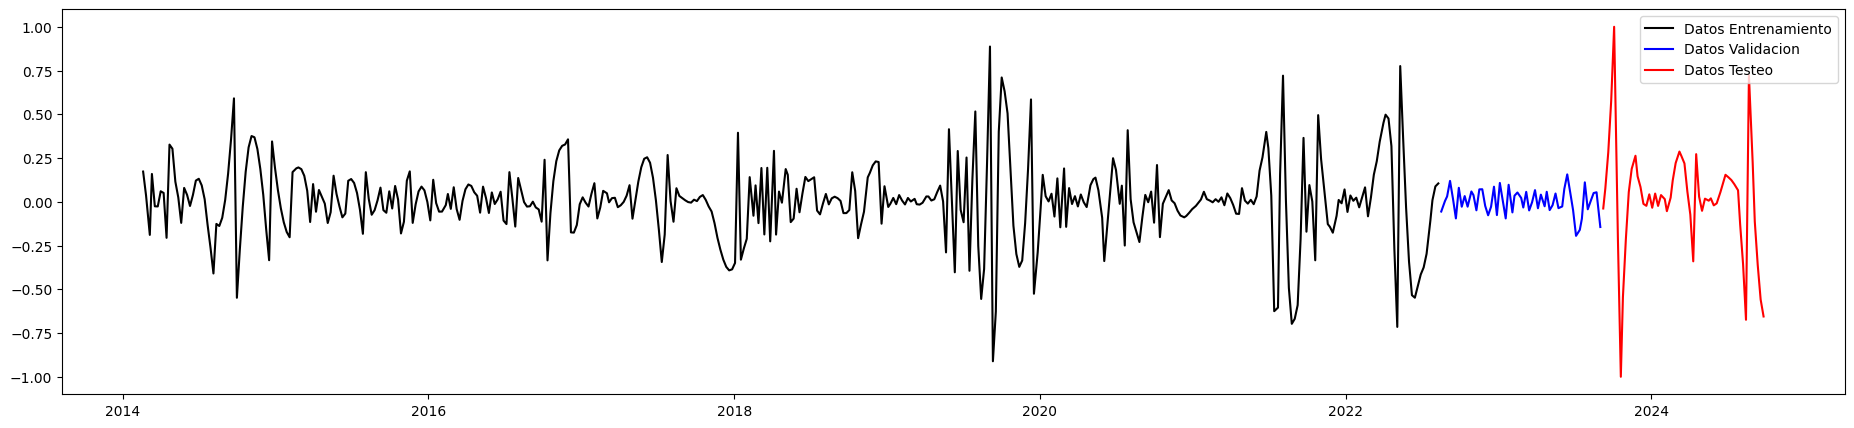

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_m1.index,datos_entrenamiento_m1.PROMEDIO,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_m1.index,datos_validacion_m1.PROMEDIO,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_m1.index,datos_testeo_m1.PROMEDIO,color='red',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

In [ ]:
neuronas_m1 = [8,9,52,25]
learning_rate_m1 = 0.00561033625564417
modeloRD_m1 = crear_modelo_densa(PASOS , neuronas_m1,learning_rate_m1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
modeloRD_m1.fit(X_train,y_train,epochs=40,batch_size=7)

Epoch 1/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2229
Epoch 2/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2059
Epoch 3/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1658
Epoch 4/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1772
Epoch 5/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1853
Epoch 6/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1634
Epoch 7/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2095
Epoch 8/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1560
Epoch 9/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2151
Epoch 10/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1837
Epoch 11/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2323
Epoch 12/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1619
Epoch 13/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1784
Epoch 14/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1803
Epoch 15/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1955
Epoch 16/40
63/63 ━

In [ ]:
prediccion_validacion_m1 = modeloRD_m1.predict(X_val)
prediccion_testeo_m1 = modeloRD_m1.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


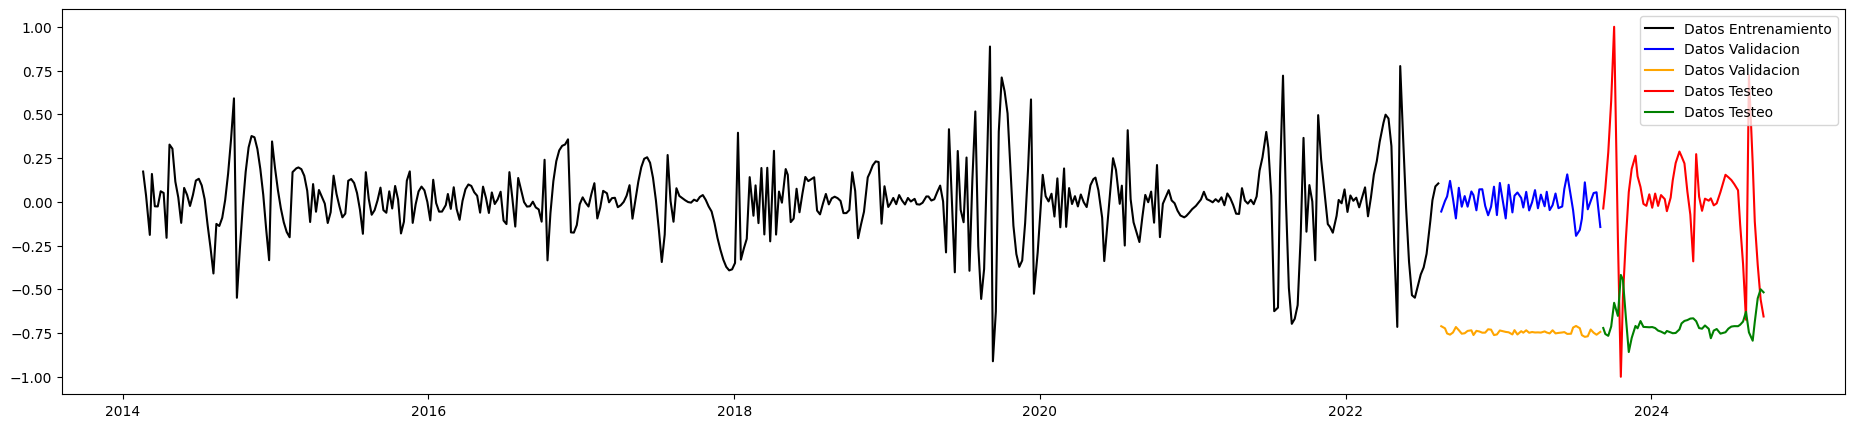

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_m1.index,datos_entrenamiento_m1.PROMEDIO,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_m1.index,datos_validacion_m1.PROMEDIO,color='blue',label = 'Datos Validacion')
ax.plot(datos_validacion_m1.index,prediccion_validacion_m1,color='orange',label = 'Datos Validacion')
ax.plot(datos_testeo_m1.index,datos_testeo_m1.PROMEDIO,color='red',label = 'Datos Testeo')
ax.plot(datos_testeo_m1.index,prediccion_testeo_m1,color='green',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

In [ ]:
score = np.sqrt(mean_squared_error(prediccion_validacion_m1,datos_validacion_m1.PROMEDIO))
print(score)

0.74977714


In [ ]:
prediccion_validacion_m1 = modo_1_scaler.inverse_transform(prediccion_validacion_m1)
prediccion_testeo_m1 = modo_1_scaler.inverse_transform(prediccion_testeo_m1 )

# Modelamos modo 2

In [ ]:
modo_2_values = modo_2.values
modo_2_values = modo_2_values.astype('float32')
modo_2_scaler = MinMaxScaler(feature_range=(-1, 1))
modo_2_escalado =  pd.DataFrame(modo_2_scaler.fit_transform(modo_2_values), columns=modo_2.columns,index=modo_2.index)
modo_2_sup = add_lags(modo_2_escalado, PASOS)
modo_2_sup = pd.merge( modo_2_sup,futuros_escalada,left_index=True, right_index=True, how='inner')
modo_2_sup.head(5)

,PROMEDIO,retraso-1,retraso-2,retraso-3,retraso-4,retraso-5,retraso-6,retraso-7,Futuro
2014-02-19,-0.087502,-0.098992,-0.108631,-0.121053,-0.130698,-0.132002,-0.125543,-0.115907,-0.409028
2014-02-26,-0.053753,-0.087502,-0.098992,-0.108631,-0.121053,-0.130698,-0.132002,-0.125543,-0.406236
2014-03-07,0.010561,-0.053753,-0.087502,-0.098992,-0.108631,-0.121053,-0.130698,-0.132002,-0.302001
2014-03-12,0.090317,0.010561,-0.053753,-0.087502,-0.098992,-0.108631,-0.121053,-0.130698,-0.303862
2014-03-19,0.108054,0.090317,0.010561,-0.053753,-0.087502,-0.098992,-0.108631,-0.121053,-0.288041


In [ ]:
total_datos=len(modo_2_sup)
#modo_4_sup = modo_4_sup.values
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento_m2 = modo_2_sup[:division_entrenamiento]
datos_validacion_m2 = modo_2_sup[division_entrenamiento:division_validacion]
datos_testeo_m2 = modo_2_sup[division_validacion:total_datos]

datos_entrenamiento_m2_values= datos_entrenamiento_m2.values
datos_validacion_m2_values = datos_validacion_m2.values
datos_testeo_m2_values = datos_testeo_m2.values

X_train, y_train = datos_entrenamiento_m2_values[:, :-1], datos_entrenamiento_m2_values[:, -1]
X_val, y_val = datos_validacion_m2_values[:, :-1], datos_validacion_m2_values[:, -1]
X_test, y_test = datos_testeo_m2_values[:, :-1], datos_testeo_m2_values[:, -1]

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape , y_test.shape)

(436, 1, 8) (436,) (54, 1, 8) (54,) (55, 1, 8) (55,)


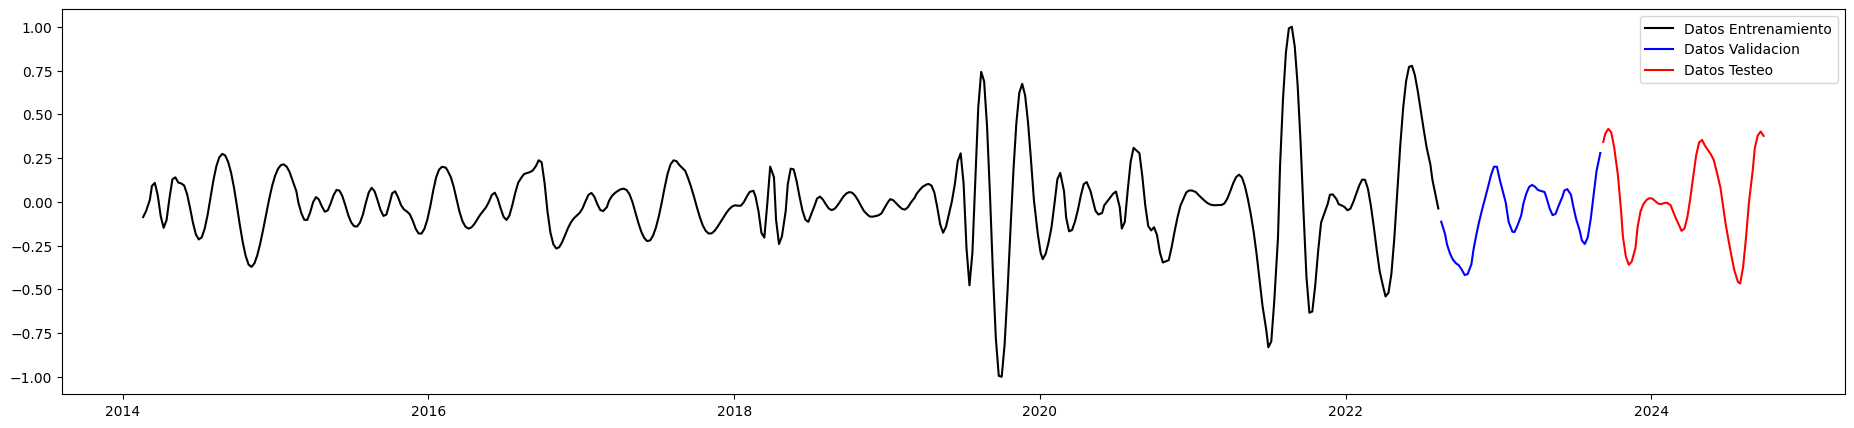

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_m2.index,datos_entrenamiento_m2.PROMEDIO,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_m2.index,datos_validacion_m2.PROMEDIO,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_m2.index,datos_testeo_m2.PROMEDIO,color='red',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

In [ ]:
# Crear un estudio Optuna
#study = optuna.create_study(direction='minimize')

# Ejecutar la optimización de hiperparámetros
#study.optimize(objective, n_trials=200)

# Obtener los mejores hiperparámetros
#best_params = study.best_params
#print("Mejores hiperparámetros:", best_params)

In [ ]:
neuronas_m2 = [11,43]
learning_rate_m2 = 0.004293605564430626
modeloRD_m2 = crear_modelo_densa(PASOS , neuronas_m2,learning_rate_m2)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
modeloRD_m2.fit(X_train,y_train,epochs=40,batch_size=7)

Epoch 1/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3276
Epoch 2/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1633
Epoch 3/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1863
Epoch 4/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1781
Epoch 5/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1935
Epoch 6/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1627
Epoch 7/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1581
Epoch 8/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1586
Epoch 9/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1607
Epoch 10/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1638
Epoch 11/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1460
Epoch 12/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1415
Epoch 13/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1515
Epoch 14/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1368
Epoch 15/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1485
Epoch 16/40
63/63 ━

In [ ]:
prediccion_validacion_m2 = modeloRD_m2.predict(X_val)
prediccion_testeo_m2 = modeloRD_m2.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


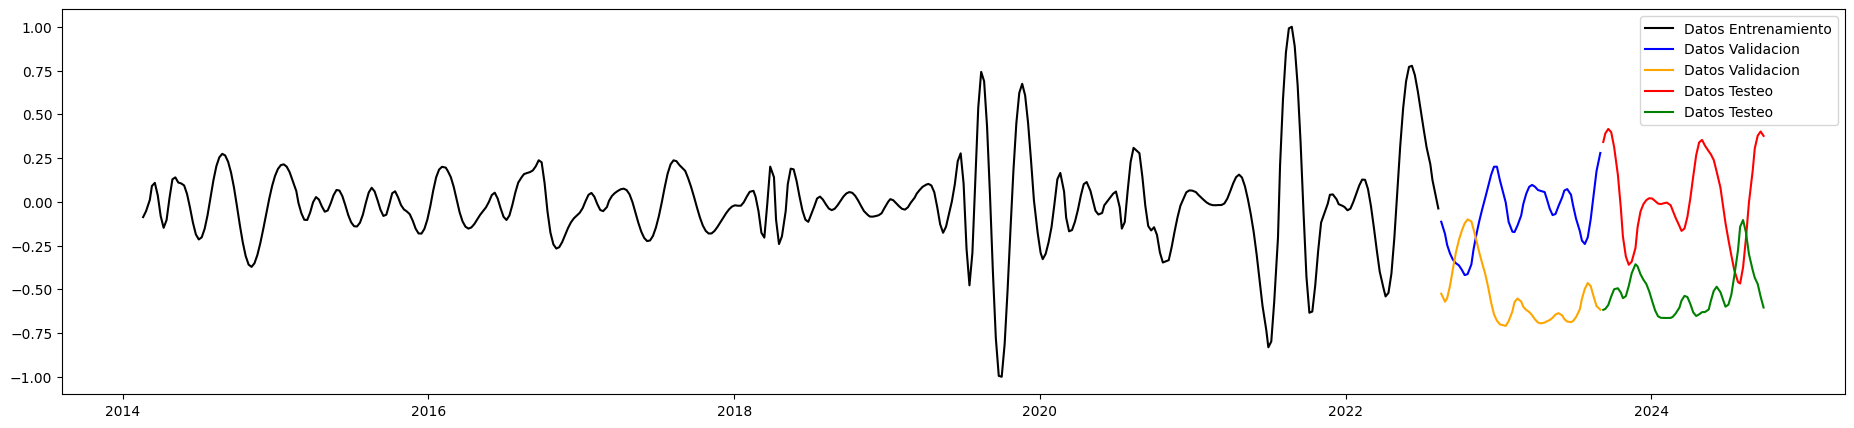

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_m2.index,datos_entrenamiento_m2.PROMEDIO,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_m2.index,datos_validacion_m2.PROMEDIO,color='blue',label = 'Datos Validacion')
ax.plot(datos_validacion_m2.index,prediccion_validacion_m2,color='orange',label = 'Datos Validacion')
ax.plot(datos_testeo_m2.index,datos_testeo_m2.PROMEDIO,color='red',label = 'Datos Testeo')
ax.plot(datos_testeo_m2.index,prediccion_testeo_m2,color='green',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

Esta actualmente en 0.2015

In [ ]:
score = np.sqrt(mean_squared_error(prediccion_validacion_m2,datos_validacion_m2.PROMEDIO))
print(score)

0.5606682


In [ ]:
prediccion_validacion_m2 = modo_2_scaler.inverse_transform(prediccion_validacion_m2)
prediccion_testeo_m2 = modo_2_scaler.inverse_transform(prediccion_testeo_m2 )

# Modelamos Residuo

In [ ]:
residuo_values = residuo.values
residuo_values = residuo_values.astype('float32')
residuo_scaler = MinMaxScaler(feature_range=(-1, 1))
residuo_escalado =  pd.DataFrame(residuo_scaler.fit_transform(residuo_values), columns=residuo.columns,index=residuo.index)
residuo_sup = add_lags(residuo_escalado, PASOS)
residuo_sup = pd.merge( residuo_sup,futuros_escalada,left_index=True, right_index=True, how='inner')
residuo_sup.head(5)

,PROMEDIO,retraso-1,retraso-2,retraso-3,retraso-4,retraso-5,retraso-6,retraso-7,Futuro
2014-02-19,-0.967619,-0.977288,-0.985017,-0.990960,-0.995275,-0.998115,-0.999638,-1.000000,-0.409028
2014-02-26,-0.955854,-0.967619,-0.977288,-0.985017,-0.990960,-0.995275,-0.998115,-0.999638,-0.406236
2014-03-07,-0.941837,-0.955854,-0.967619,-0.977288,-0.985017,-0.990960,-0.995275,-0.998115,-0.302001
2014-03-12,-0.925414,-0.941837,-0.955854,-0.967619,-0.977288,-0.985017,-0.990960,-0.995275,-0.303862
2014-03-19,-0.906428,-0.925414,-0.941837,-0.955854,-0.967619,-0.977288,-0.985017,-0.990960,-0.288041


In [ ]:
total_datos=len(residuo_sup)

porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento_residuo = residuo_sup[:division_entrenamiento]
datos_validacion_residuo = residuo_sup[division_entrenamiento:division_validacion]
datos_testeo_residuo= residuo_sup[division_validacion:total_datos]

datos_entrenamiento_residuo_values= datos_entrenamiento_residuo.values
datos_validacion_residuo_values = datos_validacion_residuo.values
datos_testeo_residuo_values = datos_testeo_residuo.values

X_train, y_train = datos_entrenamiento_residuo_values[:, :-1], datos_entrenamiento_residuo_values[:, -1]
X_val, y_val = datos_validacion_residuo_values[:, :-1], datos_validacion_residuo_values[:, -1]
X_test, y_test = datos_testeo_residuo_values[:, :-1], datos_testeo_residuo_values[:, -1]

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape , y_test.shape)

(436, 1, 8) (436,) (54, 1, 8) (54,) (55, 1, 8) (55,)


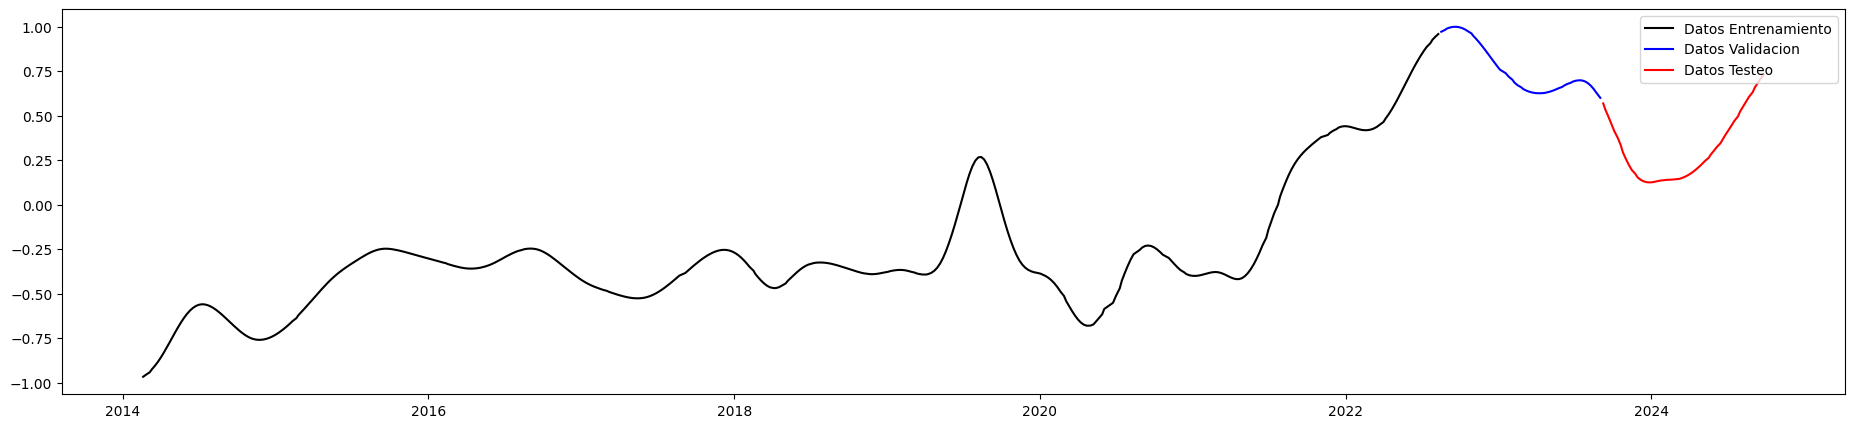

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_residuo.index,datos_entrenamiento_residuo.PROMEDIO,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_residuo.index,datos_validacion_residuo.PROMEDIO,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_residuo.index,datos_testeo_residuo.PROMEDIO,color='red',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

In [ ]:
# Crear un estudio Optuna
#study = optuna.create_study(direction='minimize')

# Ejecutar la optimización de hiperparámetros
#study.optimize(objective, n_trials=200)

# Obtener los mejores hiperparámetros
#best_params = study.best_params
#print("Mejores hiperparámetros:", best_params)

In [ ]:
neuronas_residuo = [8,29]
learning_rate_residuo = 0.01189594707899419

In [ ]:
modeloRD_residuo = crear_modelo_densa(PASOS , neuronas_residuo,learning_rate_residuo)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
modeloRD_residuo.fit(X_train,y_train,epochs=40,batch_size=7)

Epoch 1/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1297
Epoch 2/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1088
Epoch 3/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0725
Epoch 4/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1047
Epoch 5/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0847
Epoch 6/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0958
Epoch 7/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0896
Epoch 8/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0884
Epoch 9/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0996
Epoch 10/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0857
Epoch 11/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0941
Epoch 12/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0839
Epoch 13/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1018
Epoch 14/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0737
Epoch 15/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0768
Epoch 16/40
63/63 ━

In [ ]:
prediccion_validacion_residuo = modeloRD_residuo.predict(X_val)
prediccion_testeo_residuo = modeloRD_residuo.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


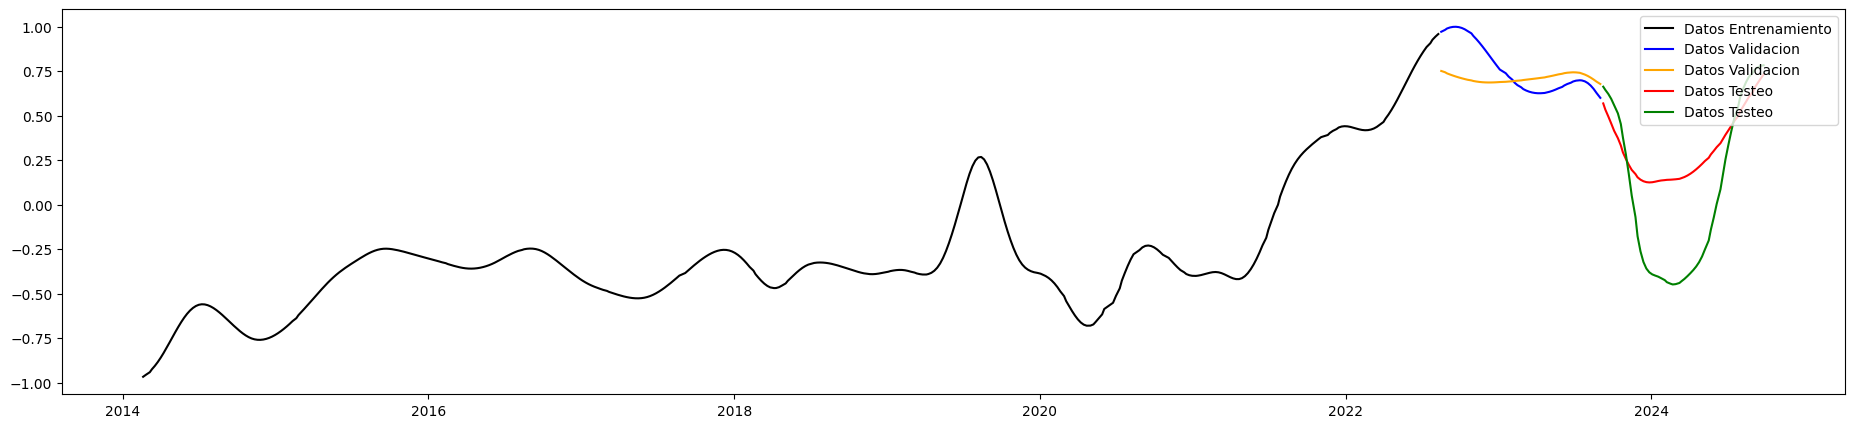

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_residuo.index,datos_entrenamiento_residuo.PROMEDIO,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_residuo.index,datos_validacion_residuo.PROMEDIO,color='blue',label = 'Datos Validacion')
ax.plot(datos_validacion_residuo.index,prediccion_validacion_residuo,color='orange',label = 'Datos Validacion')
ax.plot(datos_testeo_residuo.index,datos_testeo_residuo.PROMEDIO,color='red',label = 'Datos Testeo')
ax.plot(datos_testeo_residuo.index,prediccion_testeo_residuo,color='green',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

In [ ]:
score = np.sqrt(mean_squared_error(prediccion_validacion_residuo,datos_validacion_residuo.PROMEDIO))
print(score)

0.15032569


In [ ]:
prediccion_validacion_residuo = residuo_scaler.inverse_transform(prediccion_validacion_residuo)
prediccion_testeo_residuo = residuo_scaler.inverse_transform(prediccion_testeo_residuo  )

# Ensemble
vamos a hacer el ensemble de todos los modelos para obtener el modelo final

In [ ]:
datos_emd
validacion = prediccion_validacion_m1 +prediccion_validacion_m2 + prediccion_validacion_residuo
testeo = prediccion_testeo_m1 +prediccion_testeo_m2 + prediccion_testeo_residuo

In [ ]:
total_datos=len(datos_emd.PROMEDIO)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)

datos_entrenamiento = datos_emd[:division_entrenamiento]
datos_validacion = datos_emd[division_entrenamiento:division_validacion]
datos_testeo = datos_emd[division_validacion:total_datos]

# Rendimiento Datos Validacion

In [ ]:
ecm_validacion = mean_squared_error( validacion,datos_validacion.PROMEDIO[:-1])
recm_validacion = np.sqrt(mean_squared_error( validacion,datos_validacion.PROMEDIO[:-1]))
eam_validacion = mean_absolute_error( validacion,datos_validacion.PROMEDIO[:-1])
EPAM_validacion = mean_absolute_percentage_error( validacion,datos_validacion.PROMEDIO[:-1])


#Imprimir las metricas de validacion del modelo
print ( f'EL error cuadratico medio del modelo es: {round(ecm_validacion,2)} ' )
print ( f'La raiz del error cuadratico medio del modelo es: {round(recm_validacion,2)} ' )
print ( f'el error absoluto medio del modelo es: {round(eam_validacion,2)} ' )
print(f"Error porcentual absoluto medio del modelo es: {round(EPAM_validacion,4)} o {round(EPAM_validacion*100,2)}%")

EL error cuadratico medio del modelo es: 115392.52 
La raiz del error cuadratico medio del modelo es: 339.69 
el error absoluto medio del modelo es: 324.74 
Error porcentual absoluto medio del modelo es: 0.1411 o 14.11%


# Randimiento Datos Testeo

In [ ]:
ecm = mean_squared_error( testeo,datos_testeo.PROMEDIO[:-1])
recm = np.sqrt(mean_squared_error( testeo,datos_testeo.PROMEDIO[:-1]))
eam = mean_absolute_error( testeo,datos_testeo.PROMEDIO[:-1])
EPAM = mean_absolute_percentage_error(testeo,datos_testeo.PROMEDIO[:-1])


#Imprimir las metricas de validacion del modelo
print ( f'El error cuadratico medio del modelo es: {round(ecm,2)} ' )
print ( f'La raiz del error cuadratico medio del modelo es: {round(recm,2)} ' )
print ( f'el error absoluto medio del modelo es: {round(eam,2)} ' )
print(f"Error porcentual absoluto medio del modelo es: {round(EPAM,4)} o {round(EPAM * 100 , 2)} %")

El error cuadratico medio del modelo es: 395145.82 
La raiz del error cuadratico medio del modelo es: 628.61 
el error absoluto medio del modelo es: 540.55 
Error porcentual absoluto medio del modelo es: 0.4038 o 40.38 %


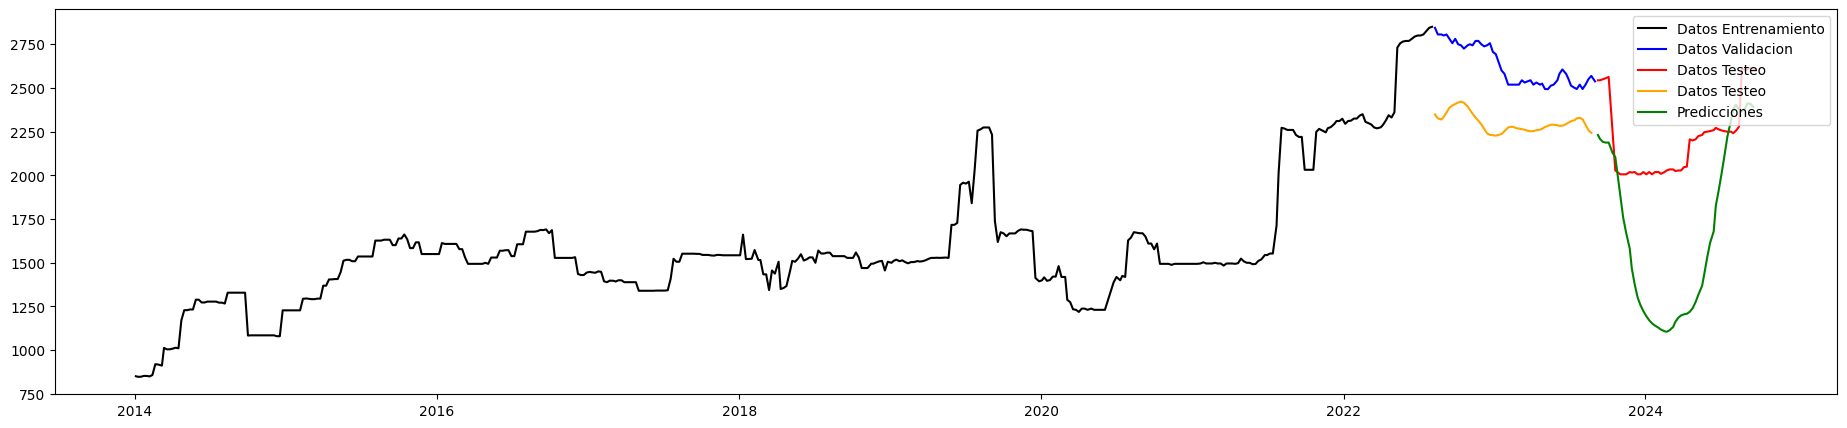

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento.index,datos_entrenamiento.PROMEDIO,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion.index,datos_validacion.PROMEDIO,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo.index,datos_testeo.PROMEDIO,color='red',label = 'Datos Testeo')
ax.plot(datos_validacion.index[:-1],validacion,color='orange',label = 'Datos Testeo')
ax.plot(datos_testeo.index[:-1],testeo,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

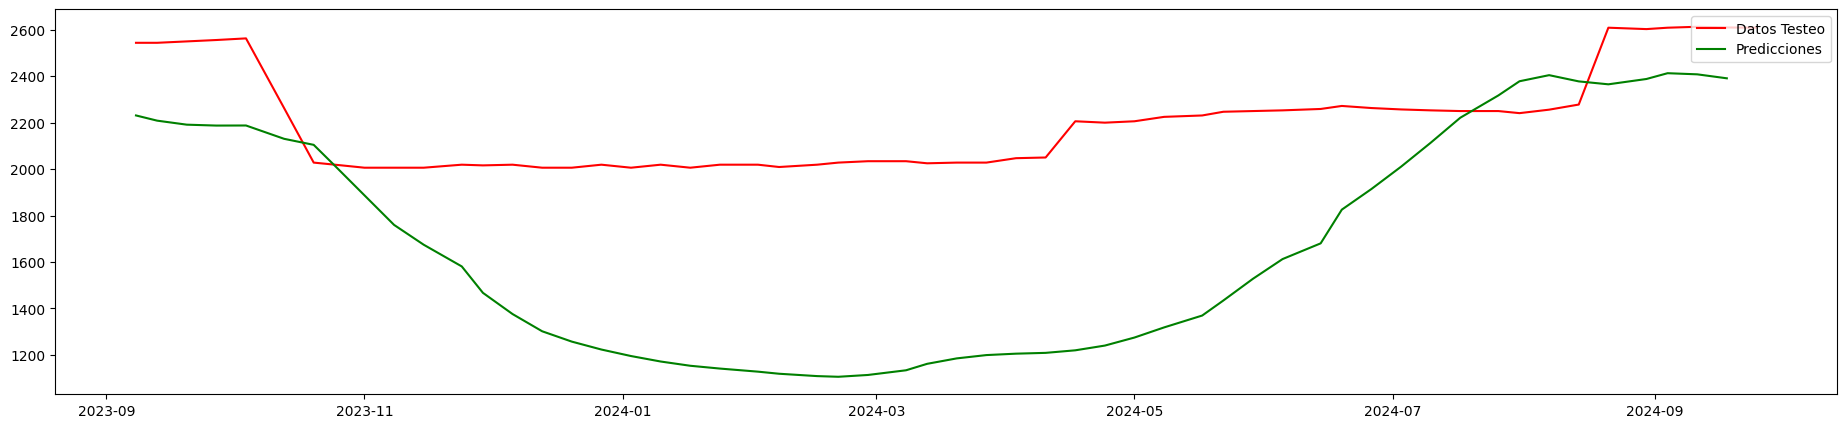

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_testeo.index,datos_testeo.PROMEDIO,color='red',label = 'Datos Testeo')
ax.plot(datos_testeo.index[:-1],testeo,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

In [ ]:
validacion =pd.DataFrame(validacion,index=datos_validacion.index[:-1],columns=['PROMEDIO'])
testeo = pd.DataFrame(testeo,index=datos_testeo.index[:-1],columns=['PROMEDIO'])

In [ ]:
validacion.to_csv("/content/drive/MyDrive/prediccion_productos_agro/Fase 5 (Datos Atlantico)/Futuros_maiz/Resultados_Futuros/validacion_red_densa.csv",index=True)
testeo.to_csv("/content/drive/MyDrive/prediccion_productos_agro/Fase 5 (Datos Atlantico)/Futuros_maiz/Resultados_Futuros/testeo_red_densa.csv",index=True)